In [1]:
%matplotlib inline
from array import array
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
from root_numpy import root2array, rec2array
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.ranking import _binary_clf_curve
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from MVA_utils import *
from IPython.core.pylabtools import figsize
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

import pickle
from sklearn.externals import joblib
import xgboost as xgb

In [2]:
tree_prefix = '/home/llr/cms/pigard/ZZjj_generator_study/'

classic_vbf = ['m_jj', 
                'dEta_tj', 
                'm_4l',
                'Z1_zepp', 
                'Z2_zepp', 
                'dPhi_Z1_Z2', 
                'tj1_eta_x_tj2_eta']
decay_angles = ['costhetastar', 
                'phi', 
                'costheta1', 
                'costheta2', 
                'phi1',
                ]
prod_angles = [
                'vbf_costhetastar',
                'vbf_costheta1',
                'vbf_costheta2',
                'vbf_phi',
                'vbf_phi1',
                'qv1',
                'qv2']

hadronic_activity = [  'ntj_n',
                'ntj_scalar_sum_pt',
                'ntj_central_n',
                'ntj_central_scalar_sum_pt']
new_var = [     'max_4l_eta',
                'tj_min_eta',
                'tj_max_eta',
                'rel_pt_hard',
                'tj_delta_rel',
                'tj_sum_abs_eta',
                'tj2_eta',
                'tj1_eta',
                'tj2_pt',
                'tj1_pt',
                'm_jj_over_dEta_tj'
          ]


qg = ['tj1_qg', 'tj2_qg']




var = ['m_jj', 
                'dEta_tj', 
                'm_4l',
                'Z1_zepp',
                'Z2_zepp',
                  #'tj1_eta_x_tj2_eta',
       'rel_pt_hard',
       'tj_delta_rel',
       #'ntj_n',
       #'tj2_qg',
       #'tj1_qg',
      ]

branch_names = var
signal = root2array(tree_prefix + 'zzjj_ewk_tight_v7_ZZ4lAnalysis_MVA_tree.root',
                    "test",
                    branch_names)


backgr = root2array(tree_prefix + 'zzjj_qcd_tight_v7_ZZ4lAnalysis_MVA_tree.root',
                    "test",
                    branch_names)

In [3]:
red_back = rec2array(backgr[var])
red_sig = rec2array(signal[var])
        
X = np.concatenate((red_sig, red_back))
y = np.concatenate((np.ones(red_sig.shape[0]) ,
                            np.zeros(red_back.shape[0])))
        
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.90, random_state=492)

In [4]:
gbdt = GradientBoostingClassifier(n_estimators=1000, learning_rate =.005, max_depth=8, random_state=0, min_samples_leaf = 800)
#gbm = xgb.XGBClassifier(max_depth=8, n_estimators=100, learning_rate=0.02, nthread=10)

est = gbdt
est.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.005, loss='deviance',
              max_depth=8, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=800, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [5]:
#joblib.dump(est, 'SKL.pkl', compress = 1)
#est = joblib.load('/home/llr/cms/pigard/ZZjj_generator_study/gbdt_best.pkl') 
#pickle.load(gbdt, open("/home/llr/cms/pigard/ZZjj_generator_study/gbdt_best.pkl", "rb" ))


est_decisions = est.predict_proba(X_test)[:, 1]
est_fpr, est_tpr, thresholds = roc_curve(y_test, est_decisions)

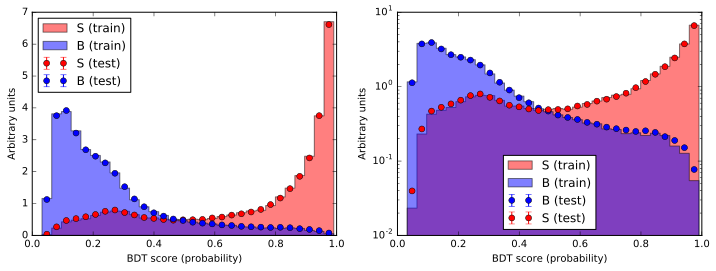

In [6]:
figsize(12, 4)
compare_train_test(est, X_train, y_train, X_test, y_test)

MVA_utils.py:92: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if X_train!=None and y_train!=None :


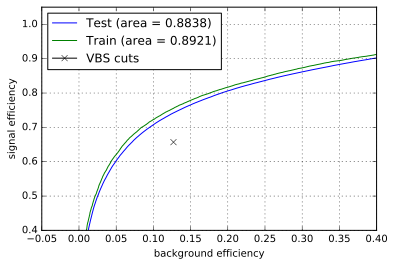

In [7]:
figsize(6, 4) 
plot_ROC(est, X_test, y_test, X_train, y_train)    

In [8]:
s_fid_s = 0.2115230295 #0.1986
s_fid_b = 2.66579147967 #2.602
luminosity = 30.

NUMBER OF BACKGROUND EVENTS AT 30.000000 fb-1:  79.9737443899
NUMBER OF SIGNAL EVENTS AT 30.000000 fb-1:  6.34569088498
Finding BDT cut value that maximizes log-significance


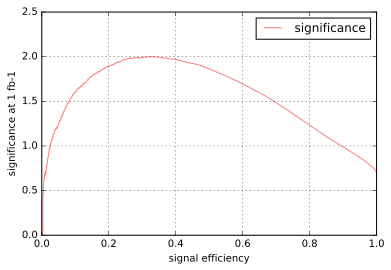

Maximum of log-significance is :  2.00195881803
Signal eff  0.326419284638
Background eff  0.00698065548102
Expected signal events at 30.000000 fb-1  2.07135587922
Expected background events at 30.000000 fb-1  0.558269157114
BDT cut value  0.928452644514


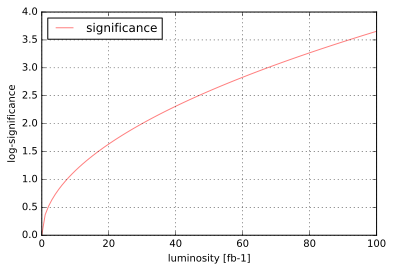

In [9]:
figsize(6, 4)
do_BDT_cut_analysis(X_test, y_test, est_decisions, luminosity = luminosity, s_fid_b = s_fid_b, s_fid_s = s_fid_s)

signal overflow:  0 in event counts at 30fb  0.0
background overflow:  0 in event counts at 30fb  0.0


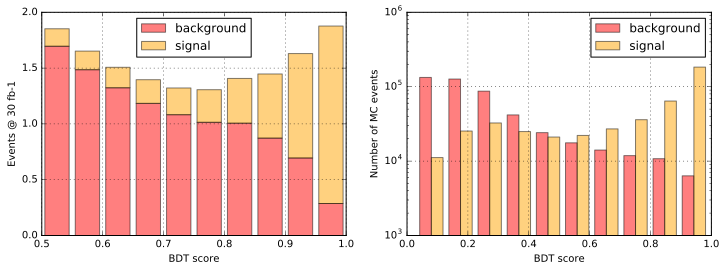

In [10]:
figsize(12,4)
plot_BDT_output(X_test, y_test, est_decisions, min_BDT = 0.5, max_BDT = 1.0, bins_BDT = 10, 
                  luminosity = luminosity, s_fid_b = s_fid_b, s_fid_s = s_fid_s)

sigma:  2.33635820012


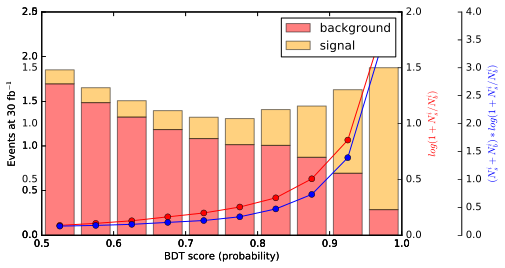

In [11]:
figsize(8,4)
plot_significance(X_test, y_test, est_decisions, min_BDT = 0.5, max_BDT = 1.0, bins_BDT = 10, 
                  luminosity = luminosity, s_fid_b = s_fid_b, s_fid_s = s_fid_s)

In [12]:
plots = {'m_jj' :(r'$m_{jj}$ [GeV]', 60 , [0, 3000]),
         'dEta_tj' :(r'$\Delta\eta_{jj}$', 20, [0, 10]),
         'm_4l' : (r'$m_{4l}$', 20, [0, 1500]),
         'Z1_zepp' : (r'$\eta^{*}_{Z_{1}}$', 30, [-5, 5]),
         'Z2_zepp' : (r'$\eta^{*}_{Z_{2}}$', 30, [-5, 5]),
         'rel_pt_hard' : ("pT of vector sum / sum of pT of Z's and tagging jets", 30, [0, 1]),
         'tj_delta_rel' : ("pT of vector sum / sum of tagging jets", 30, [0, 1]),
         'tj1_eta' : ('tj1_eta', 30, [-5, 5]),
         'tj1_pt' : ('tj1_pt', 50, [0, 500]),
         'ntj_n' : ('ntj_n', 5, [0, 5]),
         'ntj_scalar_sum_pt' : ('ntj_scalar_sum_pt', 50, [0, 500]),
         'ntj_central_n' : ('ntj_central_n', 6, [-1, 5]),
         'ntj_central_scalar_sum_pt' : ('ntj_central_scalar_sum_pt', 50, [0, 500]),
         'tj1_qg' : ('QG likelihood leading jet', 50, [-1, 1]),
         'tj2_qg' :('QG likelihood sub-leading jet', 50, [-1, 1]),       
         }


figsize(18, 4)
plot_BDT_selection(plots, 'm_jj', var, X_test, y_test, est_decisions, 0.928074429843, luminosity = luminosity, s_fid_b = s_fid_b, s_fid_s = s_fid_s)
plot_BDT_selection(plots, 'm_4l', var, X_test, y_test, est_decisions, 0.928074429843, luminosity = luminosity, s_fid_b = s_fid_b, s_fid_s = s_fid_s)
plot_BDT_selection(plots, 'dEta_tj', var, X_test, y_test, est_decisions, 0.928074429843, luminosity = luminosity, s_fid_b = s_fid_b, s_fid_s = s_fid_s)
plot_BDT_selection(plots, 'Z1_zepp', var, X_test, y_test, est_decisions, 0.928074429843, luminosity = luminosity, s_fid_b = s_fid_b, s_fid_s = s_fid_s)

/opt/exp_soft/cms/jupyter/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


Welcome to ROOTaaS 6.06/00


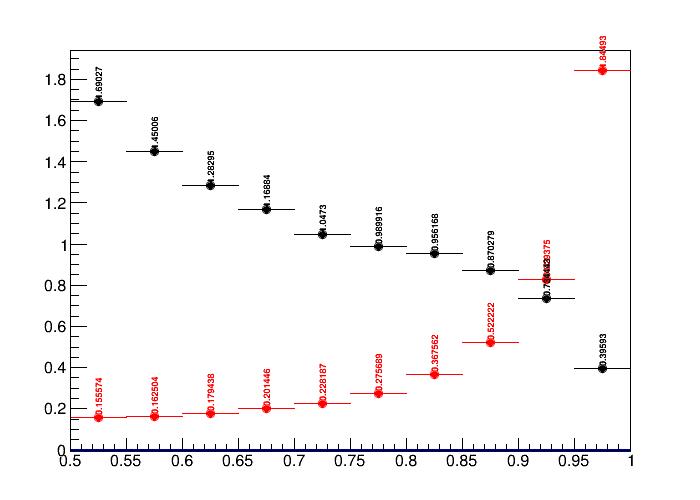

[ 1.69016494  1.45001469  1.28293898  1.16885495  1.04734534  0.9899658
  0.95621313  0.87031259  0.73445809  0.39591882]
[ 0.1555599   0.16248595  0.17941157  0.20140779  0.22813469  0.27563973
  0.36756213  0.52225804  0.82893044  1.84289543]


In [13]:
BDT_bkg = est_decisions[y_test < 0.5]
BDT_sig = est_decisions[y_test > 0.5]   

X_test_bkg = X_test[y_test < 0.5]
X_test_sig = X_test[y_test > 0.5]

bkg_weight = luminosity*s_fid_b / sum(np.ones(np.shape(X_test_bkg[:,0]))) * np.ones(np.shape(X_test_bkg[:,0]))
sig_weight = luminosity*s_fid_s  / sum(np.ones(np.shape(X_test_sig[:,0]))) * np.ones(np.shape(X_test_sig[:,0]))

from rootpy.io import root_open
myfile = root_open('BDT_proba.root', 'recreate')
from rootpy.plotting import Hist, HistStack, Legend, Canvas

h_QCD = Hist(10, 0.5, 1, name="BDT_prob_QCD", title="some title")
h_QCD.fill_array(BDT_bkg, bkg_weight)
h_EWK = Hist(10, 0.5, 1, name="BDT_prob_EWK", title="some title")
h_EWK.color = 'red'
h_EWK.fill_array(BDT_sig, sig_weight)
# plot with ROOT
canvas = Canvas(width=700, height=500)

stack = HistStack()
stack.Add(h_EWK)
stack.Add(h_QCD)
stack.Draw('nostack text')
canvas.Modified()
canvas.Update()
canvas.Draw()

h_QCD.Write()
h_EWK.Write()
myfile.close()
n, _, _ = plt.hist([BDT_bkg, BDT_sig], 
             bins=10, range=(0.5, 1) , weights = [bkg_weight, sig_weight]
             , lw=1, alpha=0.5, color = ['red', 'orange'], label=['background', 'signal'], stacked = True)

print n[0]
print n[1] - n[0] # second histo is stack!


In [14]:
myfile = root_open('BDT_proba.root', 'read')
myfile.keys()
myfile.close()

False

In [15]:


n, bins, _ = plt.hist([BDT_bkg, BDT_sig], 
             bins=bins_BDT, range=(min_BDT, max_BDT)
             , lw=1, alpha=0.5, color = ['red', 'orange'], label=['background', 'signal'])
print n

sig = n[1]
bkg = n[0]
print sig

print sig / (sig + bkg)

NameError: name 'bins_BDT' is not defined

In [ ]:
sigma:  2.20843212217 :
    var = ['m_jj', 
                'dEta_tj', 
                'm_4l',
                'Z1_zepp',
                'Z2_zepp',
                  #'tj1_eta_x_tj2_eta',
       'rel_pt_hard'
      ] 
    
sigma:  2.129450645 :
     var = ['m_jj', 
                'dEta_tj', 
                'm_4l',
                'Z1_zepp',
                'Z2_zepp',
      ]   
    
sigma:  2.03962135573 :
      var = ['m_jj', 
                'dEta_tj', 
                'm_4l',
                'Z1_zepp',
                #'Z2_zepp',
      ] 
    
    
sigma:  2.2526591343
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.9, random_state=492)   
gbdt = GradientBoostingClassifier(n_estimators=1400, learning_rate =.01, max_depth=8, random_state=0, min_samples_leaf = 800)
var = ['m_jj', 
                'dEta_tj', 
                'm_4l',
                'Z1_zepp',
                'Z2_zepp',
                  #'tj1_eta_x_tj2_eta',
       'rel_pt_hard'
      ]

sigma:  2.31479753398

var = ['m_jj', 
                'dEta_tj', 
                'm_4l',
                'Z1_zepp',
                'Z2_zepp',
                  #'tj1_eta_x_tj2_eta',
       'rel_pt_hard',
       'tj_delta_rel',
      ]

sigma:  2.38026813923 :
var = ['m_jj', 
                'dEta_tj', 
                'm_4l',
                'Z1_zepp',
                'Z2_zepp',
                  #'tj1_eta_x_tj2_eta',
       'rel_pt_hard',
       'tj_delta_rel',
       'ntj_n'
      ]

sigma:  2.43520421229
    var = ['m_jj', 
                'dEta_tj', 
                'm_4l',
                'Z1_zepp',
                'Z2_zepp',
                  #'tj1_eta_x_tj2_eta',
       'rel_pt_hard',
       'tj_delta_rel',
       'ntj_n',
       'tj2_qg',
       'tj1_qg',
      ]
    
for v7    
sigma: sigma:  2.44858887017 

        for 800 trees:
sigma:  2.45932145697
    
    
sigma:  2.31774130334
